Про задачу __Img2Img__:

- Есть 2 множества изображений ($A$ и $B$)
- Задача - научиться превращать изображения из множества $A$ в изображения из множества $B$ и наоборот
- Бывают paired и unpaired множества
- В случае __paired__ множеств - для каждого изображения из $A$ существует конкретное изображение из $B$, в которое оно должно перейти (и наоборот). Примером такой пары множеств может быть (а) спутниковая фотграфия местности vs схематическая карта местности , (б) фотография фасада здания vs схема фасада здания , ...
- В случае __unpaired__ множеств - между множествами нет конкретных пар. Примером такой пары множеств может быть (а) фотографии с лошадьми vs фотографии с зебрами , (б) фотографии vs рисунки конкретного художника

---

Про модель __CycleGAN__:

- Модель придумана для задачи Img2Img (в первую очередь unpaired версии) и основана на концепции GAN-ов
- В модели есть 2 генератора: $G_{A -> B}$ (задача которого - принимая на вход изображение из множества $A$ переводить его в изображение из множества $B$) и $G_{B -> A}$ (аналогично в другую сторону)
- Надо отметить что на вход генераторы не получают никакую дополнительную случайность, что делает обучение таких моделей проще
- В модели так же есть 2 дискриминатора: $D_{A}$ (задача которого - отличать реальные изображения из $A$ от сгенерированных с помощью $G_{B -> A}$ изображений) и $D_{B}$ (аналогично для $B$)
- Функцией ошибки будет, как и для GAN-ов, minmax игра между генераторами и дискриминаторами, но к ошибке генераторов добавится ещё и, так называемый, `cycle consistency loss`, который проверяет, что после двойного перехода изображения не меняются $G_{B -> A} \big( G_{A -> B} ( a ) \big) = a ; \forall a \in A$ и $G_{A -> B} \big( G_{B -> A} ( b ) \big) = b ; \forall b \in B$
- Так же можно добавлять или нет штраф за то, чтобы $G_{B -> A}$ не меняла изображения из $A$ и наоборот $G_{A -> B}$ не меняла изображения из $B$
- Оригинальная статья: https://arxiv.org/pdf/1703.10593.pdf

---

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

from torchvision import datasets, transforms as tr

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Для тёмной темы jupyter
plt.style.use('dark_background')

from tqdm.auto import tqdm, trange

import os
import sys
import requests
import cv2

from dataclasses import dataclass

from collections import OrderedDict
from functools import partial
from itertools import chain

# 1. Подготовка данных (___2 балла___)

## 1.1 Выбор и скачивание датасета

In [ ]:
dataset_folder = "datasets/img2img"
num_images_per_split = 5

os.environ["dataset_folder"] = dataset_folder
!mkdir -p ${dataset_folder}

# В этом цикле каждый из предложенных датасетов
#  - скачивается
#  - распаковывается
#  - отрисовывается + meta
#  - удаляется
for dataset_name in [
    # Unpaired
    # "apple2orange",
    # "summer2winter_yosemite",
    # "horse2zebra",
    # "monet2photo",
    # "cezanne2photo",
    # "ukiyoe2photo",
    "vangogh2photo",
    # Paired
    # "maps",
    # "facades",
]:
    print(f"Dataset '{dataset_name}'")
    url = f"http://efrosgans.eecs.berkeley.edu/cyclegan/datasets/{dataset_name}.zip"
    download_path = os.path.join(dataset_folder, f"{dataset_name}.zip")
    target_folder = os.path.join(dataset_folder, dataset_name)
    
    # Чтобы bash вызовы знали соответствующие переменные
    os.environ["url"] = url
    os.environ["download_path"] = download_path
    os.environ["target_folder"] = target_folder
    
    print("Loading zip file...", end="")
    # Проверяем что нет такого загруженого файла
    if not os.path.isfile(download_path) or os.path.exists(target_folder):
        # # Можно загрузить через requests библиотеку
        # response = requests.get(url)
        # open(download_path, "wb").write(response.content)
        
        # Можно загрузить через wget
        !wget ${url} -O ${download_path}
    print(" --> done!")
    
    print("Unziping...", end="")
    # Распаковываем
    if os.path.exists(target_folder):
        !rm -r ${target_folder}
    !mkdir -p ${dataset_folder}
    !unzip -qq ${download_path} -d ${dataset_folder}
    print(" --> done!")
    
    # Удаляем zip-файл
    !rm ${download_path}
    
    # Meta + Отрисовка
    print(f"Provided splits: {os.listdir(target_folder)}")
    # Удобный способ быстро получить датасет картинок с лэйблами, если картинки разложены по папкам в формате:
    # root_folder/label_name/img.jpg
    # (в нашем случае нет лэйблов, но картинки разложены в таком же формате, просто вместо label_name идёт
    #  split_name: trainA/testA/trainB/testB)
    dataset = datasets.ImageFolder(target_folder)

    inds_to_show = {i: [] for i, _ in enumerate(dataset.classes)}
    classes_full = 0
    for dataset_ind in range(len(dataset)):
        _, split_ind = dataset[dataset_ind]
        if len(inds_to_show[split_ind]) == num_images_per_split:
            continue
        inds_to_show[split_ind].append(dataset_ind)
        if len(inds_to_show[split_ind]) == num_images_per_split:
            classes_full += 1
        if classes_full == len(dataset.classes):
            break

    for split_name in sorted(dataset.classes):
        split_ind = dataset.class_to_idx[split_name]
        print(f"Split '{split_name}' of dataset '{dataset_name}'", end="")
        split_folder = os.path.join(target_folder, split_name)
        print(f" --> size: {len(os.listdir(split_folder))}")

        plt.subplots(1, num_images_per_split, figsize=(5 * num_images_per_split, 5))
        plt.suptitle(f"{dataset_name} ~ {split_name}", y=0.95)
        for i, dataset_ind in enumerate(inds_to_show[split_ind]):
            plt.subplot(1, num_images_per_split, i + 1)
            plt.imshow(dataset[dataset_ind][0])
            plt.xticks([])
            plt.yticks([])
        plt.show()
    
    # Удаляем скачанный датасет
    # !rm -r ${target_folder}
    
    print("\n----------------------------\n")

## 1.2 Dataset и Transforms

В папке `target_folder` находятся несколько папок со сплитами для соответствующего датасета, в каждой папке сплита находятся сами `.jpg` изображения.

Давайте составим их в удобном для нас виде в отдельные датасеты для каждого сплита без лэйблов.

Для получения картинок можно использовать 
```python
cv2.imread(img_path)[:, :, ::-1]  # каналы записаны в обратном порядке
```

In [ ]:
# Выбранный выше и скачанный датасет
dataset_name = "vangogh2photo"
target_folder = os.path.join(dataset_folder, dataset_name)

# Класс для датасета изображений без лэйблов с применением трансформов
class ImageDatasetNoLabel(Dataset):
    def __init__(self, images_path, transforms=None, verbose=True):
        super(ImageDatasetNoLabel).__init__()
        self.images = []
        self.transforms = transforms
        error_count = 0
        for file in os.listdir(images_path):
            path = os.path.join(images_path, file)
            img = cv2.imread(path)
            if img is not None:
                img = img[:, :, ::-1]
                self.images.append(img)
            else:
                print(f"error reading '{path}'")
                error_count += 1
        if verbose:
            print(f'error readinig images {error_count} out of {error_count + len(self.images)}')
        
    def __getitem__(self, index):
        img = self.images[index]
        if self.transforms:
            img = self.transforms(img)
        return img
    
    def __len__(self):
        return len(self.images)

# Удобный класс для хранения всех наших датасетов
@dataclass
class DatasetsClass:
    train_a: ImageDatasetNoLabel
    train_b: ImageDatasetNoLabel
    test_a: ImageDatasetNoLabel
    test_b: ImageDatasetNoLabel


# Все датасеты без трансформов - чтобы посчитать статистики
ds = DatasetsClass(
    train_a=ImageDatasetNoLabel(os.path.join(target_folder, "trainA")),
    train_b=ImageDatasetNoLabel(os.path.join(target_folder, "trainB")),
    test_a=ImageDatasetNoLabel(os.path.join(target_folder, "testA")),
    test_b=ImageDatasetNoLabel(os.path.join(target_folder, "testB")),
)

error reading '/home/jupyter/datasphere/project/datasets/img2img/vangogh2photo/trainA/.ipynb_checkpoints'
error readinig images 1 out of 401
error readinig images 0 out of 6287
error reading '/home/jupyter/datasphere/project/datasets/img2img/vangogh2photo/testA/.ipynb_checkpoints'
error readinig images 1 out of 401
error readinig images 0 out of 751


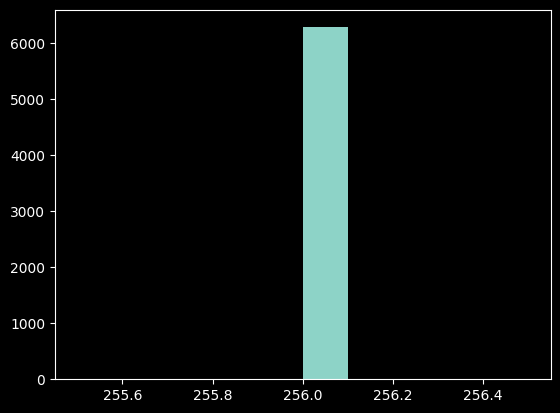

In [4]:
def show_img_shapes(images_path):
    shapes = []
    for file in os.listdir(images_path):
        path = os.path.join(images_path, file)
        img = cv2.imread(path)
        if img is not None:
            shapes.append(img.shape[:2])
    shapes = np.array(shapes)
    plt.hist(shapes[:, 0])
# show_img_shapes(os.path.join(target_folder, "trainA"))
show_img_shapes(os.path.join(target_folder, "trainB"))

In [5]:
from tqdm import tqdm
def get_channel_statistics(dataset):
    """
    Функция для получения поканальных статистик (среднее и отклонение) по датасету
    """
    channel_mean = np.zeros(3)
    channel_std = np.zeros(3)
    for img in tqdm(dataset):
        channel_mean += img.mean(axis=(0, 1))
        channel_std += img.std(axis=(0, 1))
    return channel_mean / len(dataset) / 255, channel_std / len(dataset) / 255

# Поканальное среднее и отклонение для A
# channel_mean_a, channel_std_a = get_channel_statistics(ds.train_a)
channel_mean_a, channel_std_a = np.array([0.51839874, 0.49518771, 0.33699873]), np.array([0.22115407, 0.2041303,  0.18823845])

print(channel_mean_a, channel_std_a)
# Поканальное среднее и отклонение для B
# channel_mean_b, channel_std_b = get_channel_statistics(ds.train_b)
channel_mean_b, channel_std_b = np.array([0.41229027, 0.40928956, 0.39267376]), np.array([0.22338789, 0.2017264, 0.21975849])
print(channel_mean_b, channel_std_b)

[0.51839874 0.49518771 0.33699873] [0.22115407 0.2041303  0.18823845]
[0.41229027 0.40928956 0.39267376] [0.22338789 0.2017264  0.21975849]


In [75]:
# Функция для получения train и val transform-ов, а так же функции для де-нормализации изображения
from sklearn.preprocessing import minmax_scale

def get_transforms(mean, std, **kwargs):
    train_transform = tr.Compose([
        tr.ToPILImage(),
        tr.Resize(256),
        tr.RandomHorizontalFlip(p=0.5),
        tr.ToTensor(),
        # tr.Normalize(mean=mean, std=std),
    ])
    
    test_transform = tr.Compose([
        tr.ToPILImage(),
        tr.Resize(256),
        tr.ToTensor(),
        # tr.Normalize(mean=mean, std=std),
    ])
    
    def de_normalize(img, **kwargs):
        img = img.cpu().numpy().transpose(1, 2, 0)
        return img
        # return minmax_scale(
        #     (img.reshape(3, -1) + mean[:, None]) * std[:, None],
        #     feature_range=(0., 1.),
        #     axis=1,
        # ).reshape(*img.shape)
    
    return train_transform, test_transform, de_normalize

hyperparams = dict()

# transform-ы для A и B
train_transform_a, val_transform_a, de_normalize_a = get_transforms(
    mean=channel_mean_a,
    std=channel_std_a,
    **hyperparams) # only scaling
train_transform_b, val_transform_b, de_normalize_b = get_transforms(
    mean=channel_mean_b,
    std=channel_std_b,
    **hyperparams)


# Функция для визуализации transform-ов
def show_examples(dataset, transform, de_norm, num_per_image=3, image_index=0, title=""):
    fig, ax = plt.subplots(1, 1 + num_per_image, figsize=(5 * (1 + num_per_image), 5))
    
    image = dataset[image_index]
    
    plt.suptitle(title, y=0.95)

    plt.subplot(1, 1 + num_per_image, 1)
    plt.imshow(image)
    plt.title("original")

    for i in range(num_per_image):
        plt.subplot(1, 1 + num_per_image, i + 2)
        plt.title(f"#{i}")
        plt.imshow(de_norm(transform(image)))
    plt.show()

# Проверка на адекватность
# show_examples(ds.train_a, train_transform_a, de_normalize_a, num_per_image=4, image_index=0, title="A #0")
# show_examples(ds.train_a, val_transform_a, de_normalize_a, num_per_image=1, image_index=0, title="A #0 - val")
# show_examples(ds.train_a, train_transform_a, de_normalize_a, num_per_image=4, image_index=1, title="A #1")
# show_examples(ds.train_a, train_transform_a, de_normalize_a, num_per_image=4, image_index=2, title="A #2")
# show_examples(ds.train_b, train_transform_b, de_normalize_b, num_per_image=4, image_index=0, title="B #0")
# show_examples(ds.train_b, val_transform_b, de_normalize_b, num_per_image=1, image_index=0, title="B #0 - val")
# show_examples(ds.train_b, train_transform_b, de_normalize_b, num_per_image=4, image_index=1, title="B #1")
# show_examples(ds.train_b, train_transform_b, de_normalize_b, num_per_image=4, image_index=2, title="B #2")

In [7]:
# Все датасеты с трансформами
ds = DatasetsClass(
    train_a=ImageDatasetNoLabel(
        os.path.join(target_folder, "trainA"),
        transforms=train_transform_a,
    ),
    train_b=ImageDatasetNoLabel(
        os.path.join(target_folder, "trainB"),
        transforms=val_transform_b,
    ),
    test_a=ImageDatasetNoLabel(
        os.path.join(target_folder, "testA"),
        transforms=val_transform_a,
    ),
    test_b=ImageDatasetNoLabel(
        os.path.join(target_folder, "testB"),
        transforms=val_transform_b,
    ),
)

error reading '/home/jupyter/datasphere/project/datasets/img2img/vangogh2photo/trainA/.ipynb_checkpoints'
error readinig images 1 out of 401
error readinig images 0 out of 6287
error reading '/home/jupyter/datasphere/project/datasets/img2img/vangogh2photo/testA/.ipynb_checkpoints'
error readinig images 1 out of 401
error readinig images 0 out of 751


## 1.3 DataLoader

In [49]:
@dataclass
class DataLoadersClass:
    train_a: DataLoader
    train_b: DataLoader
    test_a: DataLoader
    test_b: DataLoader

batch_size = 14 # in paper they used batch_size = 1

dataloaders = DataLoadersClass(
    train_a=DataLoader(
        dataset=ds.train_a,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
    ),
    train_b=DataLoader(
        dataset=ds.train_b,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
    ),
    test_a=DataLoader(
        dataset=ds.test_a,
        batch_size=batch_size,
        shuffle=False,
        drop_last=True,
    ),
    test_b=DataLoader(
        dataset=ds.test_b,
        batch_size=batch_size,
        shuffle=False,
        drop_last=True,
    ),
)

# 2. Модель

## 2.0 Вспомогательные модули и классы

In [13]:
def get_norm_layer(name):
    if name == 'batch_norm':
        # use in discriminators, classifiers
        return partial(nn.BatchNorm2d, affine=True, track_running_stats=True)
    elif name == 'instance_norm':
        # use when per-instance/style normalization is more critical than batch-wide statistics,
        # basically in generators
        return partial(nn.InstanceNorm2d, affine=False, track_running_stats=False)
    raise NotImplementedError

In [69]:
def get_scheduler(optimizer, name, params=None):
    if name == 'cosine':
        assert params is not None
        return torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, **params)
    raise NotImplementedError

In [11]:
class PreActivationBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, norm_layer, act=nn.ReLU, **kwargs):
        super().__init__()
        self.conv_block = self.get_block(in_size, out_size, norm_layer, act, padding)
        self.adapt = nn.Conv2d(in_channels=in_size, out_channels=out_size, kernel_size=1) if in_size != out_size else nn.Identity()
        
    def get_block(self, in_size, out_size, norm_layer, act, padding):
        # norm -> relu -> pad? -> conv  ->  norm -> relu -> pad? -> conv
        def block_part(in_size, out_size):
            conv_part = [norm_layer(in_size), act()]
            p = 0
            if padding == 'reflect':
                conv_part += [nn.ReflectionPad2d(1)] # Reflection reduces artifacts
            elif padding == 'replicate':
                conv_part += [nn.ReplicationPad2d(1)]
            else:
                p = "same"
            conv_part += [nn.Conv2d(in_channels=in_size, out_channels=out_size, kernel_size=3, padding=p)]
            return conv_part        
        conv_block = block_part(in_size, out_size) + block_part(out_size, out_size)
        return nn.Sequential(*conv_block)
    
    def forward(self, x):
        return self.adapt(x) + self.conv_block(x)

In [14]:
model = PreActivationBlock(3, 10, padding="reflect", norm_layer=get_norm_layer('batch_norm'))
model(torch.zeros(10, 3, 256, 256)).shape

torch.Size([10, 10, 256, 256])

**Generator Architecture** (from paper):\
Let c7s1-k denote a 7×7 Convolution-InstanceNormReLU layer with k filters and stride 1.\
dk denotes a 3 × 3 Convolution-InstanceNorm-ReLU layer with k filters and stride 2.\
Reflection padding was used to reduce artifacts.\
Rk denotes a residual block that contains two 3 × 3 convolutional layers with the same number of filters on both layer.\
uk denotes a 3 × 3 fractional-strided-ConvolutionInstanceNorm-ReLU layer with k filters and stride 1/2.\
The network with 6 residual blocks consists of:\
c7s1-64,d128,d256,R256,R256,R256,\
R256,R256,R256,u128,u64,c7s1-3\
The network with 9 residual blocks consists of:\
c7s1-64,d128,d256,R256,R256,R256,\
R256,R256,R256,R256,R256,R256,u128\
u64,c7s1-3

In [19]:

def use_bias(norm_layer):
    if isinstance(norm_layer, partial):
        return norm_layer.func != nn.BatchNorm2d
    else:
        return norm_layer != nn.BatchNorm2d

class Generator(nn.Module):
    def __init__(self, in_size, out_size, hidden_size=64, padding="reflect", num_blocks=9, norm_layer=nn.InstanceNorm2d, act=nn.ReLU, **kwargs):
        super().__init__()
        bias = use_bias(norm_layer)
        layers = [nn.ReflectionPad2d(3),
                  nn.Conv2d(in_channels=in_size, out_channels=hidden_size, kernel_size=7, bias=bias),
                  norm_layer(hidden_size),
                  act()]
        downsampling = [hidden_size * (2 ** i) for i in range(3)]
        layers += [self.get_sampling_block(in_size=downsampling[i], 
                                           out_size=downsampling[i + 1], 
                                           norm_layer=norm_layer, 
                                           act=act, 
                                           bias=bias,
                                           downsampling=True)
                   for i in range(len(downsampling) - 1)]
        
        layers += [PreActivationBlock(downsampling[-1], downsampling[-1], padding, norm_layer, act) for _ in range(num_blocks)]
        
        upsampling = [downsampling[-1] // (2 ** i) for i in range(3)]
        [hidden_size * 4, hidden_size * 2, hidden_size]
        layers += [self.get_sampling_block(in_size=upsampling[i], 
                                           out_size=upsampling[i + 1], 
                                           norm_layer=norm_layer, 
                                           act=act, 
                                           bias=bias,
                                           downsampling=False)
                   for i in range(len(upsampling) - 1)]
        
        layers += [nn.ReflectionPad2d(3),
                   nn.Conv2d(upsampling[-1], out_size, kernel_size=7, padding=0),
                   nn.Tanh()]
        self.layers = nn.Sequential(*layers)
        
    def get_sampling_block(self, in_size, out_size, norm_layer, act, bias, downsampling=True):
        conv_class = nn.Conv2d if downsampling else partial(nn.ConvTranspose2d, output_padding=1)
        block = [conv_class(in_channels=in_size, out_channels=out_size, kernel_size=3, stride=2, padding=1, bias=bias),
                 norm_layer(out_size),
                 act(),
                 ]
        return nn.Sequential(*block)
    
    def forward(self, x):
        return self.layers(x)
        

In [20]:
model = Generator(3, 3, norm_layer=get_norm_layer('instance_norm'))
model(torch.zeros(2, 3, 256, 256)).shape

torch.Size([2, 3, 256, 256])

**Discriminator Architecture** (from paper):\
For discriminator networks, we use 70 × 70 PatchGAN\
Let Ck denote a 4 × 4 Convolution-InstanceNorm-LeakyReLU layer with k filters and stride 2.\
After the last layer, we apply a convolution to produce a 1-dimensional output.\
We do not use InstanceNorm for the first C64 layer. We use leaky ReLUs with a slope of 0.2.\
The discriminator architecture is: C64-C128-C256-C512
    

In [21]:
class Discriminator(nn.Module):
    def __init__(self, in_size, norm_layer=nn.InstanceNorm2d, act=nn.LeakyReLU):
        super().__init__()
        hidden_sizes = [in_size, 64, 128, 256, 512]
        layers = [self.get_block(in_size=hidden_sizes[i], 
                        out_size=hidden_sizes[i + 1], 
                        norm_layer=norm_layer if i > 0 else None, 
                        act=act) 
                  for i in range(len(hidden_sizes) - 1)]
        layers += [nn.Conv2d(in_channels=hidden_sizes[-1], out_channels=1, kernel_size=1, stride=1, padding=1)]
        self.layers = nn.Sequential(*layers)

    def get_block(self, in_size, out_size, norm_layer, act):
        block = [nn.Conv2d(in_channels=in_size, out_channels=out_size, kernel_size=4, stride=2, padding=1)]
        if norm_layer:
            block += [norm_layer(out_size)]
        if act:
            block += [act()]
        return nn.Sequential(*block)

    def forward(self, x):
        return self.layers(x).squeeze(-3)

In [22]:
model = Discriminator(3, act=partial(nn.LeakyReLU, negative_slope=0.2))
model(torch.zeros(2, 3, 256, 256)).shape

torch.Size([2, 18, 18])

## 2.1 Архитектура сети

In [23]:
class CycleGAN(nn.Module):
    def __init__(self, gen_params, discr_params):
        super(CycleGAN, self).__init__()
        self.Ga2b = Generator(in_size=3, out_size=3, **gen_params) # A -> B
        self.Gb2a = Generator(in_size=3, out_size=3, **gen_params) # B -> A
        self.Da   = Discriminator(in_size=3, **discr_params) # A -> {0, 1}
        self.Db   = Discriminator(in_size=3, **discr_params) # B -> {0, 1}

## 2.2 Loss

$$ \mathbf{L}_{\text{cyc}} \big( G_{A \rightarrow B}, G_{B \rightarrow A} \big) = \mathbb{E}_{a \sim A} \bigg( \Big\| G_{B \rightarrow A} \big( G_{A \rightarrow B} ( a ) \big) - a \Big\|_1 \bigg) + \mathbb{E}_{b \sim B} \bigg( \Big\| G_{A \rightarrow B} \big( G_{B \rightarrow A} ( b ) \big) - b \Big\|_1 \bigg) \longrightarrow \min_{G}$$

In [24]:
class CycleConsistencyLoss(nn.Module):
    """
    Функция ошибки, проверяющая что после двойного перехода через генераторы изображение не изменилось
    """
    def __init__(self):
        super(CycleConsistencyLoss, self).__init__()
        self.criterion = nn.L1Loss()
    
    def forward(self, a, a_rec, b, b_rec):
        # Принимает на вход оригинальное изображение и изображение после двойного перехода
        return self.criterion(a, a_rec).mean() + self.criterion(b, b_rec).mean()

In [25]:
CycleConsistencyLoss()(torch.randn(4, 3, 256, 256), torch.randn(4, 3, 256, 256), torch.randn(4, 3, 256, 256), torch.randn(4, 3, 256, 256))

tensor(2.2543)

$$ \mathbf{L}_{\text{GAN}} \big( G_{A \rightarrow B}, D_{B} \big) = \mathbb{E}_{b \sim B} \log D_{B} (b) + \mathbb{E}_{a \sim A} \log \Big( 1 - D_{B} \big( G_{A \rightarrow B} (a) \big) \Big) \longrightarrow \min_{G} \max_{D}$$

In [26]:
class AdversarialLossCE(nn.Module):
    """
    Стандартная функция ошибки для minmax игры GAN-ов
    """
    def __init__(self):
        super(AdversarialLossCE, self).__init__()
        self.criterion = nn.BCEWithLogitsLoss(reduction='mean')
    
    def forward(self, pred, gen_pred=None):
        if gen_pred is not None:
            device = pred.device
            return - (self.criterion(pred, torch.ones_like(pred, device=device)) + \
                   self.criterion(gen_pred, torch.ones_like(gen_pred, device=device)))
        else:
            # one parameter -> pred is gen_pred :)
            return - (self.criterion(pred, torch.ones_like(pred)))

In [27]:
model = Discriminator(3, act=partial(nn.LeakyReLU, negative_slope=0.2))
gen_pred = model(torch.randn(2, 3, 256, 256) * 1 + 10)
pred = model(torch.randn(50, 3, 256, 256) * 0.5 + 1)
AdversarialLossCE()(pred, gen_pred)

tensor(-1.3185, grad_fn=<NegBackward0>)

$$ \mathbb{E}_{b \sim B} \big( D_{B} (b) - 1 \big)^2 + \mathbb{E}_{a \sim A} \Big( D_{B} \big( G_{A \rightarrow B} (a) \big) \Big)^2 \longrightarrow \min_{D} $$
$$ \mathbb{E}_{a \sim A} \Big( D_{B} \big( G_{A \rightarrow B} (a) \big) - 1 \Big)^2 \longrightarrow \min_{G} $$

In [28]:
class AdversarialLossMSE(nn.Module):
    """
    Можно переписать не через CE, а через MSE loss на одном предсказании, помогает со стабильностью
    """
    def __init__(self):
        super(AdversarialLossMSE, self).__init__()

    def forward(self, pred, gen_pred=None):
        if gen_pred is not None:
            return torch.mean((pred - 1) ** 2) + torch.mean(gen_pred ** 2)
        else:
            # one parameter -> pred is gen_pred :)
            return torch.mean((pred - 1) ** 2)

In [29]:
AdversarialLossMSE()(pred, gen_pred)

tensor(1.0221, grad_fn=<AddBackward0>)

$$ \mathbf{L} \big( G_{A \rightarrow B}, G_{B \rightarrow A}, D_{A}, D_{B} \big) = \mathbf{L}_{\text{GAN}} \big( G_{A \rightarrow B}, D_{B} \big) + \mathbf{L}_{\text{GAN}} \big( G_{B \rightarrow A}, D_{A} \big) + \lambda \cdot \mathbf{L}_{\text{cyc}} \big( G_{A \rightarrow B}, G_{B \rightarrow A} \big) \longrightarrow \min_{G} \max_{D}$$

In [30]:
class FullDiscriminatorLoss(nn.Module):
    """
    Полная ошибка для дискриминатора
    """
    def __init__(self, is_mse=True):
        super(FullDiscriminatorLoss, self).__init__()
        # In practice, we divide the objective by 2 while
        # optimizing D, which slows down the rate at which D learns,
        # relative to the rate of G
        self.factor = (1 if is_mse else -1) / 2
        self.adversarial_loss_func = AdversarialLossMSE() if is_mse else AdversarialLossCE()
    
    def forward(
        self,
        pred_a,
        gen_pred_a,
        pred_b,
        gen_pred_b
    ):
        return self.factor * (self.adversarial_loss_func(pred_a, gen_pred_a) + self.adversarial_loss_func(pred_b, gen_pred_b))

In [31]:
model = Discriminator(3, act=partial(nn.LeakyReLU, negative_slope=0.2))
gen_pred = model(torch.randn(2, 3, 256, 256) * 1 + 10)
pred = model(torch.randn(50, 3, 256, 256) * 0.5 + 1)
FullDiscriminatorLoss(True)(pred, gen_pred, pred, gen_pred)

tensor(1.9492, grad_fn=<MulBackward0>)

In [32]:
class FullGeneratorLoss(nn.Module):
    """
    Полная ошибка для генератора
    """
    def __init__(self, lambda_value=10., is_mse=True):
        super(FullGeneratorLoss, self).__init__()
        self.adversarial_loss_func = AdversarialLossMSE() if is_mse else AdversarialLossCE()
        self.cycle_consistency_loss_func = CycleConsistencyLoss()
        self.lambda_value = lambda_value
    
    def forward(
        self,
        gen_pred_a, 
        gen_pred_b,
        a,
        a_rec,
        b,
        b_rec
    ):
        return self.adversarial_loss_func(gen_pred_a) + self.adversarial_loss_func(gen_pred_b) + \
               self.lambda_value * self.cycle_consistency_loss_func(a=a, 
                                                                    a_rec=a_rec, 
                                                                    b=b,
                                                                    b_rec=b_rec)

# 3. Подготовка обучения

## 3.1 Шаг обучения дискриминатора

In [57]:
def train_discriminators(model, opt_d, loader_a, loader_b, criterion_d):
    model.train()
    losses_tr = []
    iter_a = iter(loader_a)
    iter_b = iter(loader_b)
    
    batches_per_epoch = min(len(iter_a), len(iter_b))
    for _ in trange(batches_per_epoch):
        imgs_a = next(iter_a).to(device)
        imgs_b = next(iter_b).to(device)
        opt_d.zero_grad()
        pred_a = model.Da(imgs_a)
        gen_pred_a = model.Da(model.Gb2a(imgs_b))
        pred_b = model.Db(imgs_b)
        gen_pred_b = model.Db(model.Ga2b(imgs_a))
        loss = criterion_d(pred_a=pred_a, 
                           gen_pred_a=gen_pred_a, 
                           pred_b=pred_b, 
                           gen_pred_b=gen_pred_b)
        
        loss.backward()
        opt_d.step()
        losses_tr.append(loss.item())
    
    return model, opt_d, np.mean(losses_tr)

## 3.2 Шаг обучения генератора

In [58]:
def train_generators(model, opt_g, loader_a, loader_b, criterion_g):
    model.train()
    losses_tr = []
    
    iter_a = iter(loader_a)
    iter_b = iter(loader_b)
    batches_per_epoch = min(len(iter_a), len(iter_b))
    
    for _ in trange(batches_per_epoch):
        imgs_a = next(iter_a).to(device)
        imgs_b = next(iter_b).to(device)
        
        opt_g.zero_grad()
        
        a_fake = model.Gb2a(imgs_b)
        b_fake = model.Ga2b(imgs_a)
        
        gen_pred_a = model.Da(a_fake)
        gen_pred_b = model.Db(b_fake)
        
        a_rec = model.Gb2a(b_fake)
        b_rec = model.Ga2b(a_fake)
        
        loss = criterion_g(gen_pred_a=gen_pred_a, 
                           gen_pred_b=gen_pred_b,
                           a=imgs_a,
                           a_rec=a_rec,
                           b=imgs_b,
                           b_rec=b_rec)
        loss.backward()
        opt_g.step()
        losses_tr.append(loss.item())
    
    return model, opt_g, np.mean(losses_tr)

## 3.3 Шаг валидации

In [ ]:
from collections import defaultdict

def val(model, loader_a, loader_b, criterion_d, criterion_g):
    model.eval()
    
    val_data = defaultdict(list)

    with torch.no_grad():
        iter_a = iter(loader_a)
        iter_b = iter(loader_b)
        batches_per_epoch = min(len(iter_a), len(iter_b))

        for _ in trange(batches_per_epoch):
            imgs_a = next(iter_a).to(device)
            imgs_b = next(iter_b).to(device)
            
            fake_a = model.Gb2a(imgs_b)
            fake_b = model.Ga2b(imgs_a)

            pred_a = model.Da(imgs_a)
            pred_b = model.Db(imgs_b)

            gen_pred_a = model.Da(fake_a)
            gen_pred_b = model.Db(fake_b)

            a_rec = model.Gb2a(fake_b)
            b_rec = model.Ga2b(fake_a)
            
            loss_d = criterion_d(pred_a=pred_a, 
                                 gen_pred_a=gen_pred_a, 
                                 pred_b=pred_b, 
                                 gen_pred_b=gen_pred_b)
            
            loss_g = criterion_g(gen_pred_a=gen_pred_a, 
                               gen_pred_b=gen_pred_b,
                               a=imgs_a,
                               a_rec=a_rec,
                               b=imgs_b,
                               b_rec=b_rec)
            
            val_data["loss D"].append(loss_d.item())
            val_data["loss G"].append(loss_g.item())
        
        val_data["loss D"] = np.mean(val_data["loss D"])
        val_data["loss G"] = np.mean(val_data["loss G"])
    
    return val_data

## 3.4 Визуализация сгенерированного

In [ ]:
def draw_imgs(model, num_images, loader_a, loader_b, de_norm_a, de_norm_b):
    model.eval()
    with torch.no_grad():
        imgs_a = next(iter(loader_a))[:num_images].to(device)
        imgs_b = next(iter(loader_b))[:num_images].to(device)
        
        fake_a = model.Gb2a(imgs_b)
        fake_b = model.Ga2b(imgs_a)
        rec_a = model.Gb2a(fake_b)
        rec_b = model.Ga2b(fake_a)
        
        fig, ax = plt.subplots(num_images, 3, figsize=(25, 15))
        plt.suptitle("Images from A", y=0.92)
        
        for ind in range(num_images):
            plt.subplot(num_images, 3, ind * 3 + 1)
            plt.title("Original from A")
            plt.imshow(de_norm_a(imgs_a[ind], normalized=True))
            plt.xticks([])
            plt.yticks([])
            
            plt.subplot(num_images, 3, ind * 3 + 2)
            plt.title("Translated to B")
            plt.imshow(de_norm_b(fake_b[ind], normalized=True))
            plt.xticks([])
            plt.yticks([])
            
            plt.subplot(num_images, 3, ind * 3 + 3)
            plt.title("Reconstructed A")
            plt.imshow(de_norm_a(rec_a[ind], normalized=True))
            plt.xticks([])
            plt.yticks([])
        
        fig, ax = plt.subplots(num_images, 3, figsize=(25, 15))
        plt.suptitle("Images from B", y=0.92)
        
        for ind in range(num_images):
            plt.subplot(num_images, 3, ind * 3 + 1)
            plt.title("Original from B")
            plt.imshow(de_norm_b(imgs_b[ind], normalized=True))
            plt.xticks([])
            plt.yticks([])
            
            plt.subplot(num_images, 3, ind * 3 + 2)
            plt.title("Translated to A")
            plt.imshow(de_norm_a(fake_a[ind], normalized=True))
            plt.xticks([])
            plt.yticks([])
            
            plt.subplot(num_images, 3, ind * 3 + 3)
            plt.title("Reconstructed B")
            plt.imshow(de_norm_b(rec_b[ind], normalized=True))
            plt.xticks([])
            plt.yticks([])
    
        plt.show()

## 3.5 Цикл обучения

In [ ]:
from IPython.display import clear_output
import warnings

def get_model_name(chkp_folder, model_name=None):
    # Выбираем имя чекпоинта для сохранения
    if model_name is None:
        if os.path.exists(chkp_folder):
            num_starts = len(os.listdir(chkp_folder)) + 1
        else:
            num_starts = 1
        model_name = f'model#{num_starts}'
    else:
        if "#" not in model_name:
            model_name += "#0"
    changed = False
    while os.path.exists(os.path.join(chkp_folder, model_name + '.pt')):
        model_name, ind = model_name.split("#")
        model_name += f"#{int(ind) + 1}"
        changed=True
    if changed:
        warnings.warn(f"Selected model_name was used already! To avoid possible overwrite - model_name changed to {model_name}")
    return model_name


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def set_requires_grad(models, requires_grad):
    for model in models:
        for param in model.parameters():
            param.requires_grad_(requires_grad)


def learning_loop(
    model,
    optimizer_g,
    optimizer_d,
    train_loader_a,
    train_loader_b,
    val_loader_a,
    val_loader_b,
    criterion_d,
    criterion_g,
    de_norm_a,
    de_norm_b,
    scheduler_d=None,
    scheduler_g=None,
    min_lr=None,
    g_iters_per_epoch=1,
    d_iters_per_epoch=1,
    epochs=10,
    val_every=1,
    draw_every=1,
    model_name=None,
    chkp_folder="./chkps",
    images_per_validation=3,
    plots=None,
    starting_epoch=0,
):
    model_name = get_model_name(chkp_folder, model_name)
    
    if plots is None:
        plots = {
            'train G': [],
            'train D': [],
            'val D': [],
            'val G': [],
            "lr G": [],
            "lr D": [],
            "hist real A": [],
            "hist gen A": [],
            "hist real B": [],
            "hist gen B": [],
        }

    for epoch in np.arange(1, epochs+1) + starting_epoch:
        print(f'#{epoch}/{epochs}:')

        plots['lr G'].append(get_lr(optimizer_g))
        plots['lr D'].append(get_lr(optimizer_d))
        
        set_requires_grad([model.Da, model.Db], requires_grad=False)
        
        # генераторы
        print(f"train generators ({g_iters_per_epoch} times)")
        loss_g = []
        for _ in range(g_iters_per_epoch):
            model, optimizer_g, loss = train_generators(model, optimizer_g, train_loader_a, train_loader_b, criterion_g)
            loss_g.append(loss)
        plots['train G'].extend(loss_g)
        
        set_requires_grad([model.Da, model.Db], requires_grad=True)
        
        # дискриминаторы
        print(f"train discriminators ({d_iters_per_epoch} times)")
        loss_d = []
        for _ in range(d_iters_per_epoch):
            model, optimizer_d, loss = train_discriminators(model, optimizer_d, train_loader_a, train_loader_b, criterion_d)
            loss_d.append(loss)
        plots['train D'].extend(loss_d)
        

        if not (epoch % val_every):
            print("validate")
            val_data = val(model, val_loader_a, val_loader_b, criterion_d, criterion_g)
            plots['val D'].append(val_data["loss D"])
            plots['val G'].append(val_data["loss G"])
            plots['hist real A'].append(val_data["real pred A"])
            plots['hist gen A'].append(val_data["fake pred A"])
            plots['hist real B'].append(val_data["real pred B"])
            plots['hist gen B'].append(val_data["fake pred B"])
            
            # Сохраняем модель
            if not os.path.exists(chkp_folder):
                os.makedirs(chkp_folder)
            torch.save(
                {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_d_state_dict': optimizer_d.state_dict(),
                    'optimizer_g_state_dict': optimizer_g.state_dict(),
                    'scheduler_d_state_dict': scheduler_d.state_dict(),
                    'scheduler_g_state_dict': scheduler_g.state_dict(),
                    'plots': plots,
                },
                os.path.join(chkp_folder, model_name + '.pt'),
            )
            
            # Шедулинг
            if scheduler_d:
                try:
                    scheduler_d.step()
                except:
                    scheduler_d.step(loss_d)
            if scheduler_g:
                try:
                    scheduler_g.step()
                except:
                    scheduler_g.step(loss_g)

        if not (epoch % draw_every):
            clear_output(True)
            
            hh = 2
            ww = 2
            plt_ind = 1
            fig, ax = plt.subplots(hh, ww, figsize=(25, 12))
            fig.suptitle(f'#{epoch}/{epochs}:')

            plt.subplot(hh, ww, plt_ind)
            plt.title('discriminators losses')
            d_plot_step = 1. / d_iters_per_epoch
            plt.plot(np.arange(d_plot_step, epoch + d_plot_step, d_plot_step), plots['train D'], 'r.-', label='train', alpha=0.7)
            plt.plot(np.arange(1, epoch + 1), plots['val D'], 'g.-', label='val', alpha=0.7)
            plt.grid()
            plt.legend()
            plt_ind += 1
            
            plt.subplot(hh, ww, plt_ind)
            plt.title('generators losses')
            g_plot_step = 1. / g_iters_per_epoch
            plt.plot(np.arange(g_plot_step, epoch + g_plot_step, g_plot_step), plots['train G'], 'r.-', label='train', alpha=0.7)
            plt.plot(np.arange(1, epoch + 1), plots['val G'], 'g.-', label='val', alpha=0.7)
            plt.grid()
            plt.legend()
            plt_ind += 1
            
            plt.subplot(hh, ww, plt_ind)
            plt.title("Discriminator A predictions")
            plt.hist(plots["hist real A"][-1], bins=50, density=True, label="real", color="green", alpha=0.7)
            plt.hist(plots["hist gen A"][-1], bins=50, density=True, label="generated", color="red", alpha=0.7)
            plt.xlim((-0.05, 1.05))
            plt.xticks(ticks=np.arange(0, 1.05, 0.1))
            plt.legend()
            plt_ind += 1
            
            plt.subplot(hh, ww, plt_ind)
            plt.title("Discriminator B predictions")
            plt.hist(plots["hist real B"][-1], bins=50, density=True, label="real", color="green", alpha=0.7)
            plt.hist(plots["hist gen B"][-1], bins=50, density=True, label="generated", color="red", alpha=0.7)
            plt.xlim((-0.05, 1.05))
            plt.xticks(ticks=np.arange(0, 1.05, 0.1))
            plt.legend()
            plt_ind += 1
            
            plt.show()
            
            draw_imgs(model, images_per_validation, val_loader_a, val_loader_b, de_norm_a, de_norm_b)
                
        
        if min_lr and get_lr(optimizer_d) <= min_lr:
            print(f'Learning process ended with early stop for discriminator after epoch {epoch}')
            break
        
        if min_lr and get_lr(optimizer_g) <= min_lr:
            print(f'Learning process ended with early stop for generator after epoch {epoch}')
            break
    
    return model, optimizer_d, optimizer_g, plots

# 4. Обучение

## 4.1 Инициализация модели и оптимайзера

In [62]:
from collections import defaultdict
from termcolor import colored


def beautiful_int(i):
    i = str(i)
    return ".".join(reversed([i[max(j, 0):j+3] for j in range(len(i) - 3, -3, -3)]))


# Подсчёт числа параметров в нашей модели
def model_num_params(model, verbose_all=True, verbose_only_learnable=False):
    sum_params = 0
    sum_learnable_params = 0
    submodules = defaultdict(lambda : [0, 0])
    for name, param in model.named_parameters():
        num_params = param.numel()
        if verbose_all or (verbose_only_learnable and param.requires_grad):
            print(
                colored(
                    '{: <65} ~  {: <9} params ~ grad: {}'.format(
                        name,
                        beautiful_int(num_params),
                        param.requires_grad,
                    ),
                    {True: "green", False: "red"}[param.requires_grad],
                )
            )
        sum_params += num_params
        sm = name.split(".")[0]
        submodules[sm][0] += num_params
        if param.requires_grad:
            sum_learnable_params += num_params
            submodules[sm][1] += num_params
    print(
        f'\nIn total:\n  - {beautiful_int(sum_params)} params\n  - {beautiful_int(sum_learnable_params)} learnable params'
    )
    
    for sm, v in submodules.items():
        print(
            f"\n . {sm}:\n .   - {beautiful_int(submodules[sm][0])} params\n .   - {beautiful_int(submodules[sm][1])} learnable params"
        )
    return sum_params, sum_learnable_params

In [63]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

def create_model_and_optimizer(model_class, model_params, lr=1e-3, device=device):
    model = model_class(**model_params)
    model = model.to(device)
    
    optimizer_d = torch.optim.Adam(
        filter(lambda x: x.requires_grad, chain(model.Da.parameters(), model.Db.parameters())),
        lr,
        betas=(0.9, 0.999)
    )
    optimizer_g = torch.optim.Adam(
        filter(lambda x: x.requires_grad, chain(model.Gb2a.parameters(), model.Ga2b.parameters())),
        lr,
        betas=(0.9, 0.999)
    )
    return model, optimizer_d, optimizer_g

## 4.2 Фактическое обучение

In [76]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

results = []

gen_params = dict(norm_layer=get_norm_layer('instance_norm'))

discr_params = dict(act=partial(nn.LeakyReLU, negative_slope=0.2), norm_layer=get_norm_layer('instance_norm'))

model, optimizer_d, optimizer_g = create_model_and_optimizer(
    model_class = CycleGAN,
    model_params = dict(gen_params=gen_params, discr_params=discr_params),
    lr = 1e-4, # maybe try lr 0.0002 and keep the same learning rate for the first 100 epochs and linearly decay the rate to zero over the next 100 epochs
    device = device,
)

num_epochs=100

scheduler_d = get_scheduler(optimizer_d, 'cosine', params=dict(T_max=num_epochs))
scheduler_g = get_scheduler(optimizer_g, 'cosine', params=dict(T_max=num_epochs))

criterion_d = FullDiscriminatorLoss()
criterion_g = FullGeneratorLoss()

sum_params, sum_learnable_params = model_num_params(model)

Ga2b.layers.1.weight                                              ~  9.408     params ~ grad: True
Ga2b.layers.1.bias                                                ~  64        params ~ grad: True
Ga2b.layers.4.0.weight                                            ~  73.728    params ~ grad: True
Ga2b.layers.4.0.bias                                              ~  128       params ~ grad: True
Ga2b.layers.5.0.weight                                            ~  294.912   params ~ grad: True
Ga2b.layers.5.0.bias                                              ~  256       params ~ grad: True
Ga2b.layers.6.conv_block.3.weight                                 ~  589.824   params ~ grad: True
Ga2b.layers.6.conv_block.3.bias                                   ~  256       params ~ grad: True
Ga2b.layers.6.conv_block.7.weight                                 ~  589.824   params ~ grad: True
Ga2b.layers.6.conv_block.7.bias                                   ~  256       params ~ grad: True
Ga2b.layer

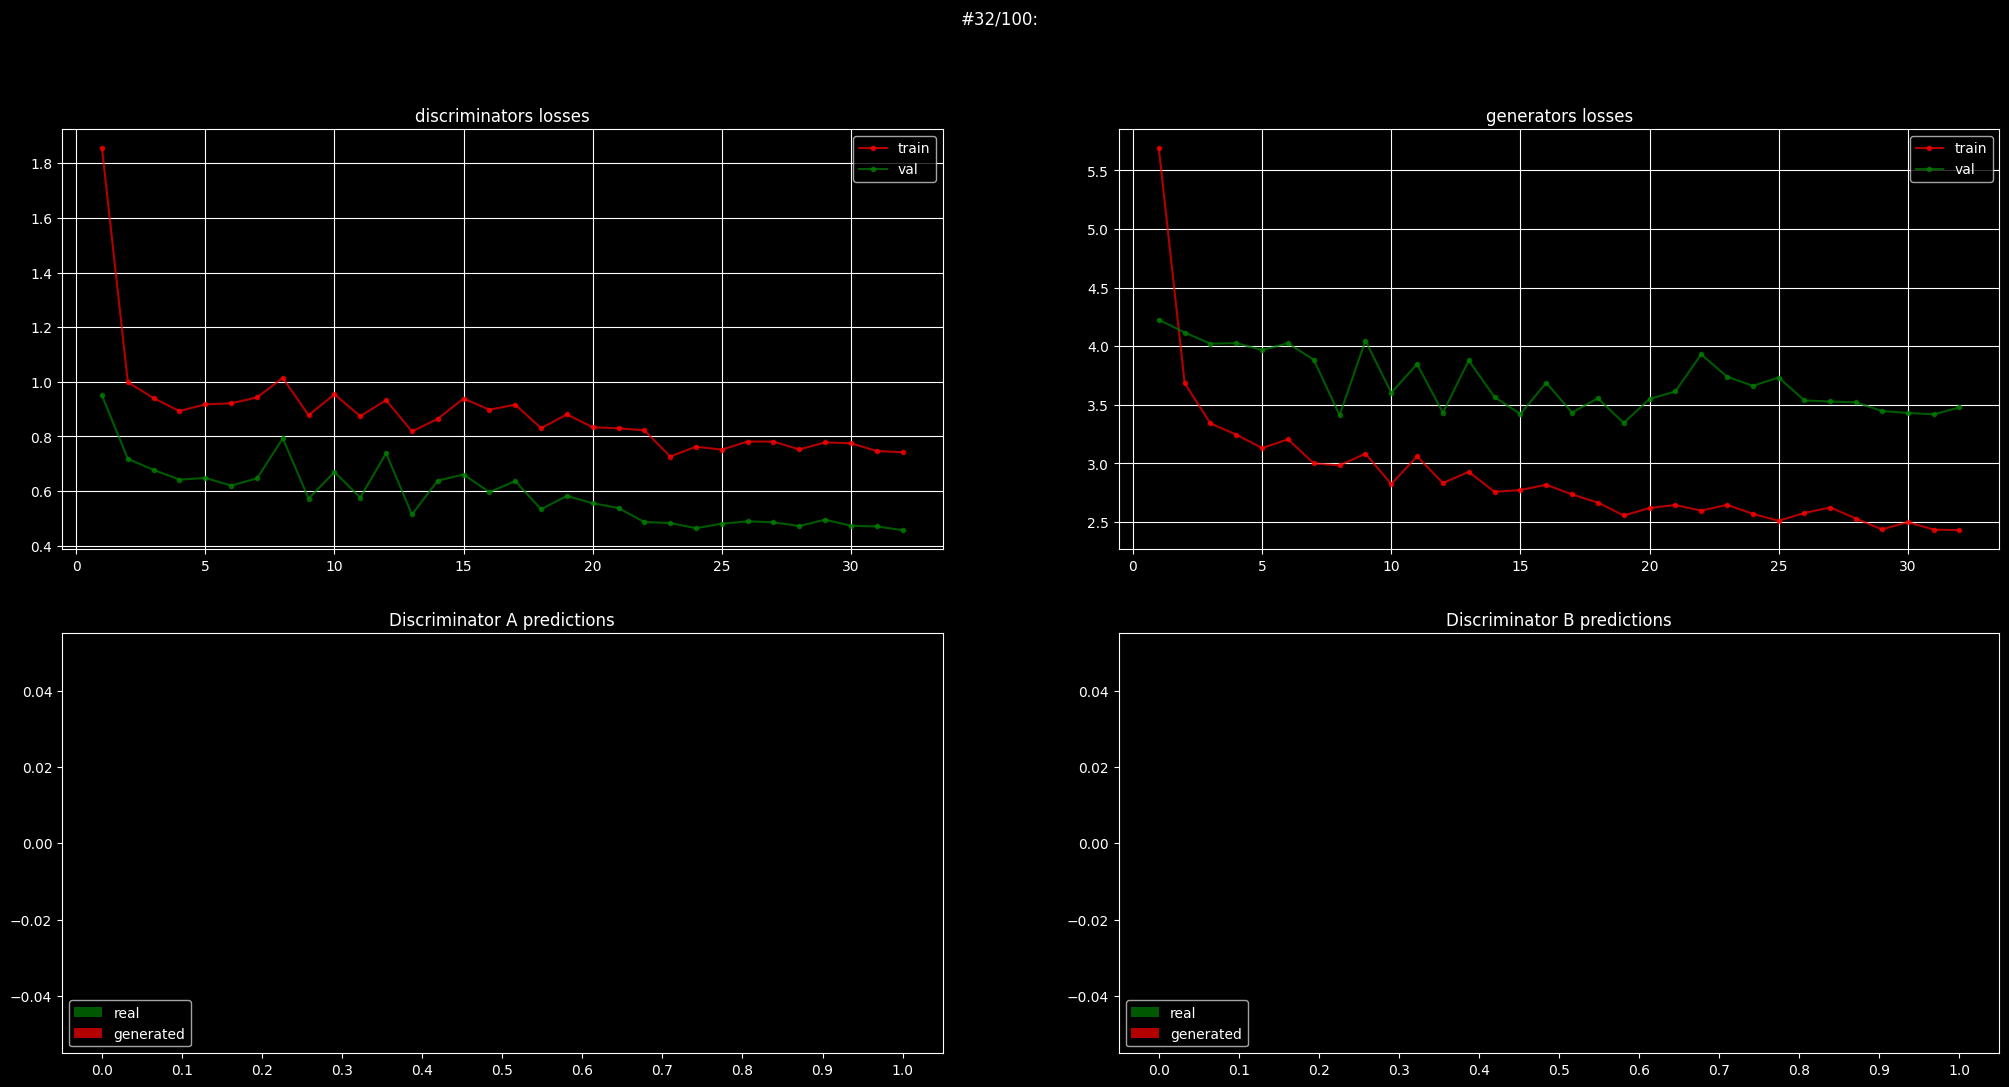

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

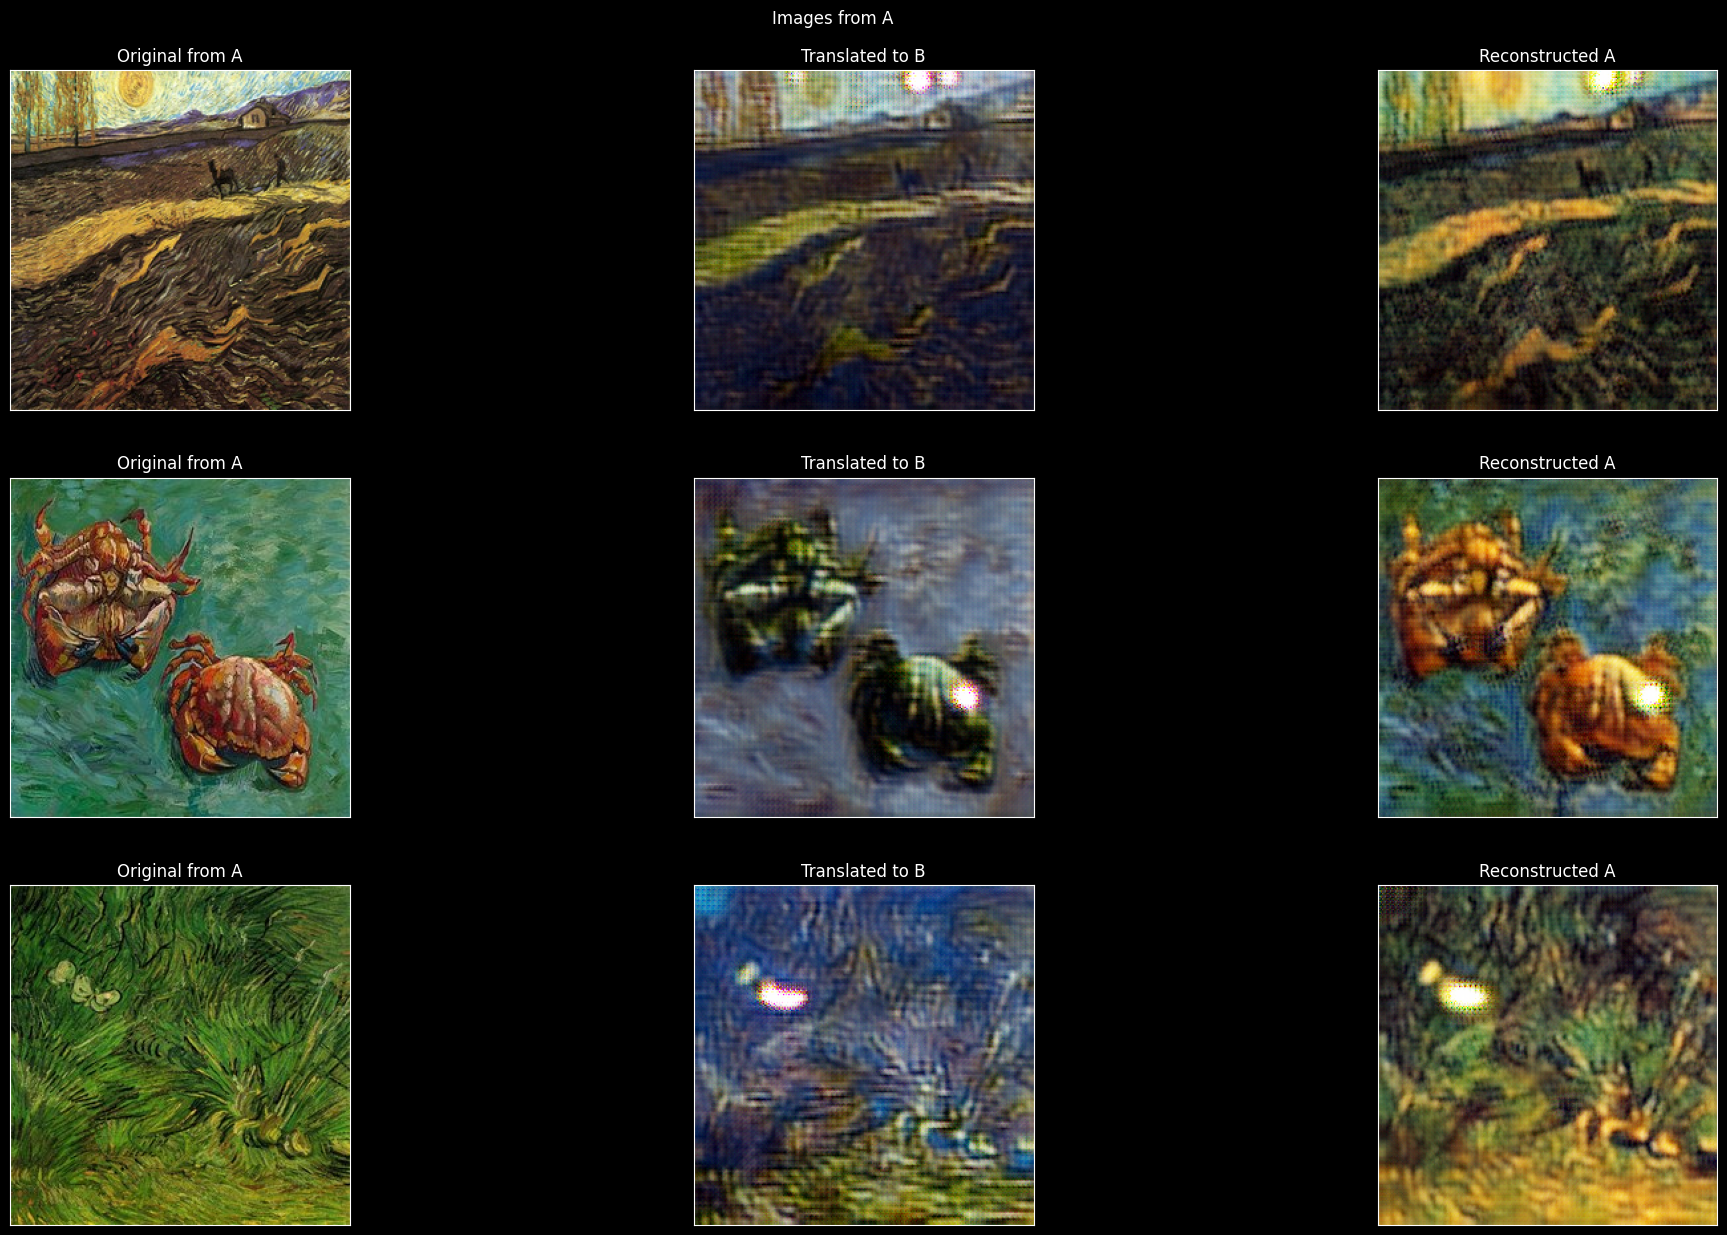

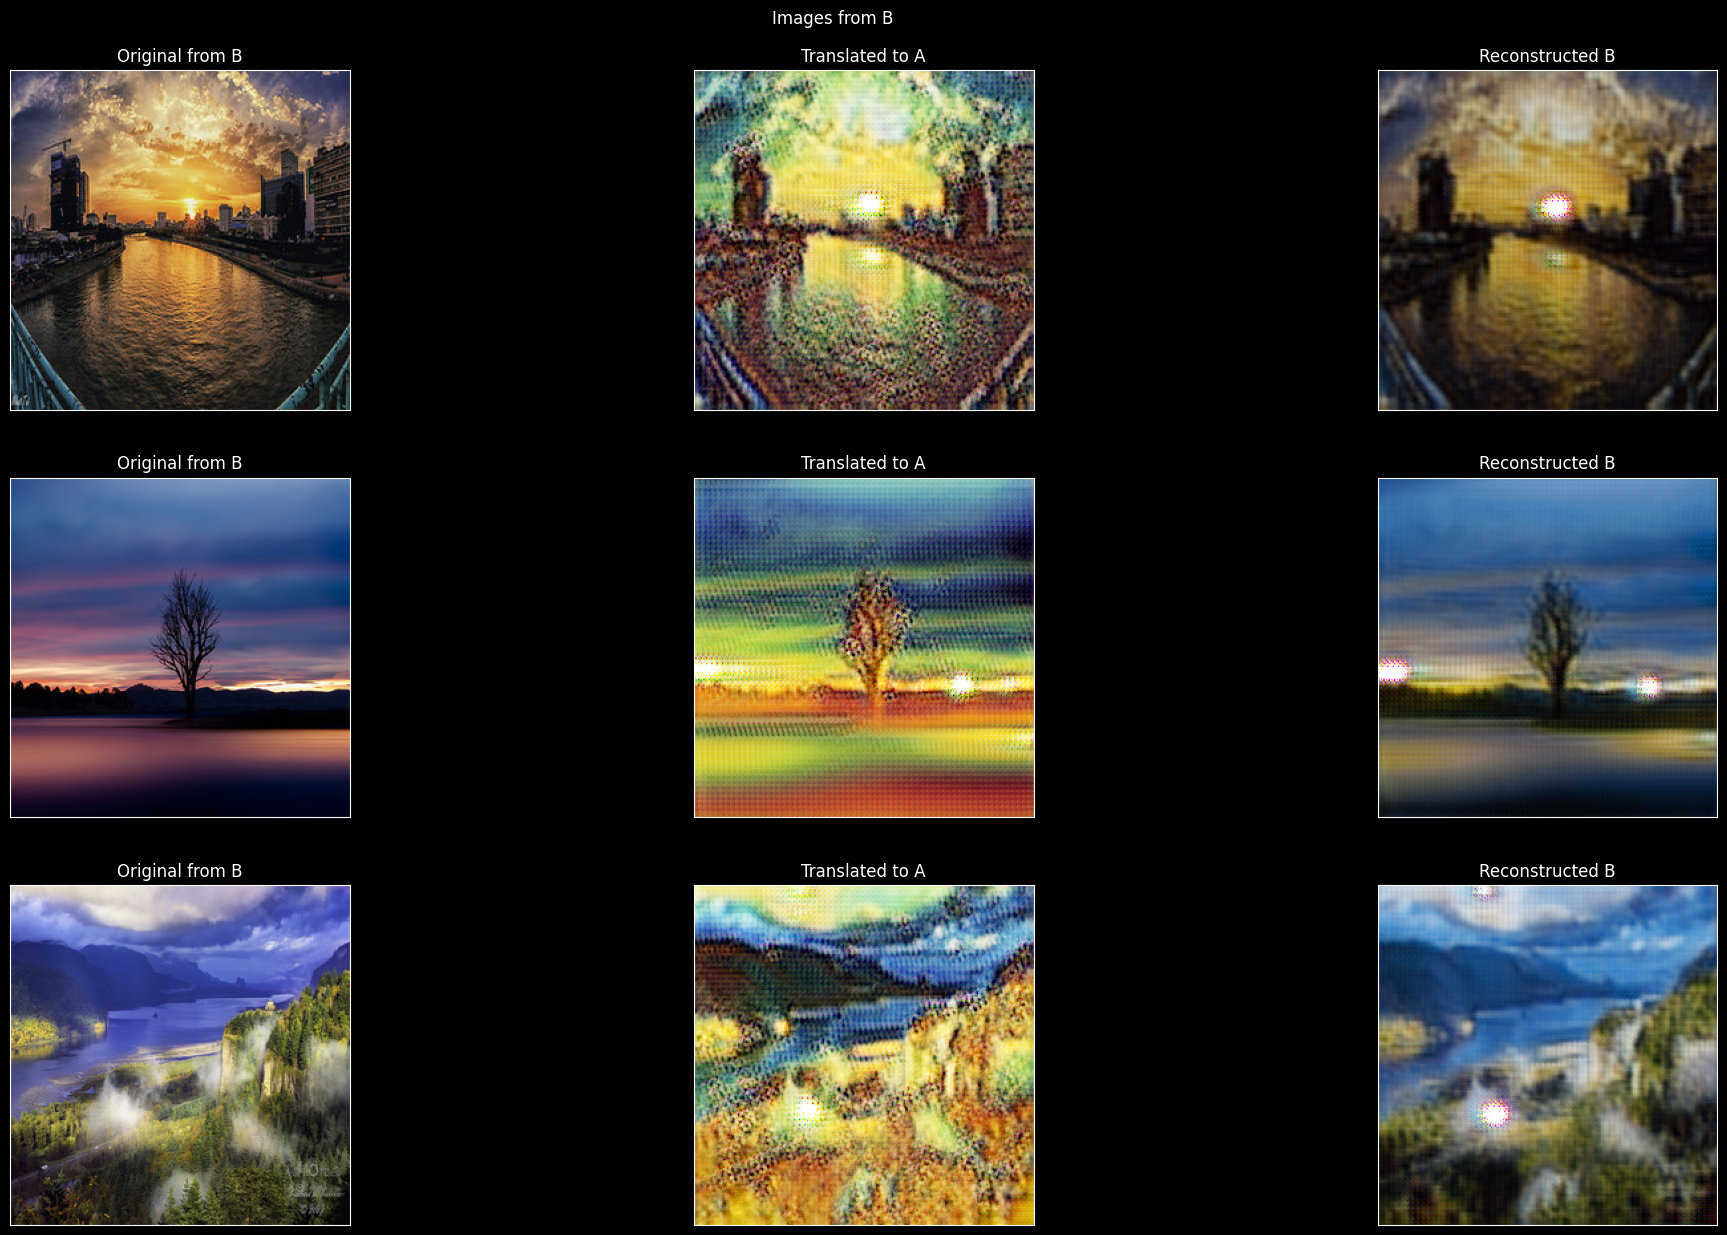

#33/100:
train generators (1 times)


100%|██████████| 50/50 [00:36<00:00,  1.38it/s]


train discriminators (1 times)


 84%|████████▍ | 42/50 [00:17<00:03,  2.38it/s]

In [ ]:

%%time
model, optimizer_d, optimizer_g, plots = learning_loop(
    model = model,
    optimizer_g = optimizer_g,
    g_iters_per_epoch = 1,
    optimizer_d = optimizer_d,
    d_iters_per_epoch = 1,
    train_loader_a = dataloaders.train_a,
    train_loader_b = dataloaders.train_b,
    val_loader_a = dataloaders.test_a,
    val_loader_b = dataloaders.test_b,
    criterion_d = criterion_d,
    criterion_g = criterion_g,
    scheduler_g = scheduler_g,
    scheduler_d = scheduler_d,
    de_norm_a = de_normalize_a,
    de_norm_b = de_normalize_b,
    epochs = num_epochs,
    min_lr = 1e-6,
    val_every = 1,
    draw_every = 1,
    chkp_folder = "./chkp",
    model_name = "cycle_gan",
    images_per_validation=3,
    plots=None,
    starting_epoch=0,
)